In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
plt.style.use('ggplot')

## Read in remote sensing snow data and explore

In [2]:
rs_data_folder = r'../data/remote_sensing/TimeSeries_thresholded'

threshold_list = []
alt_list = []
catchment_list = []

rs_dict = {}  # key: (catchment, threshold, altitude)

file_list = os.scandir(rs_data_folder)

for item in file_list:
    if item.is_file():  # Otherwise was getting ipython checkpoints too

        catchment = item.name.split('_')[0]
        threshold = int(item.name.split('_')[-3][3:])
        altitude = item.name.split('_')[-2]

        # Make list of unique names
        if catchment not in catchment_list:
            catchment_list.append(catchment)
        if threshold not in threshold_list:
            threshold_list.append(threshold)
        if altitude not in alt_list:
            alt_list.append(altitude)

        # Read data and add sum column for checking
        df = pd.read_csv(item, sep='\t', index_col=0, parse_dates=True)
        # df['Sum'] = df.sum(axis=1, min_count=2)

        # Add total snow cover (hopefully equal to bare ground 100-bare ground%)
        df['SumSnow'] = df[['WetSnow', 'DrySnow']].sum(axis=1, min_count=2)

        rs_dict[(catchment, threshold, altitude)] = df
rs_dict.keys()

dict_keys([('Maalselvfossen', 5, '0-500'), ('Divielva', 20, '0-2500'), ('Vassområde196', 10, '500-2500'), ('Maalselvfossen', 10, '0-2500'), ('Divielva', 5, '500-2500'), ('Divielva', 10, '0-500'), ('Olsborg', 10, '0-2500'), ('Olsborg', 5, '0-2500'), ('Vassområde196', 20, '0-500'), ('Olsborg', 20, '0-2500'), ('Maalselvfossen', 5, '0-2500'), ('Vassområde196', 10, '0-500'), ('Maalselvfossen', 20, '0-500'), ('Divielva', 10, '500-2500'), ('Olsborg', 10, '500-2500'), ('Olsborg', 20, '500-2500'), ('Vassområde196', 5, '0-500'), ('Divielva', 20, '0-500'), ('Olsborg', 5, '0-500'), ('Olsborg', 5, '500-2500'), ('Barduelva', 5, '0-2500'), ('Olsborg', 10, '0-500'), ('Vassområde196', 5, '0-2500'), ('Vassområde196', 20, '500-2500'), ('Vassområde196', 20, '0-2500'), ('Maalselvfossen', 5, '500-2500'), ('Vassområde196', 10, '0-2500'), ('Barduelva', 10, '0-500'), ('Barduelva', 5, '0-500'), ('Divielva', 5, '0-2500'), ('Divielva', 5, '0-500'), ('Barduelva', 20, '0-2500'), ('Maalselvfossen', 10, '0-500'), ('M

### Quick plot

Text(0.5, 1.0, "('Maalselvfossen', 20, '0-2500')")

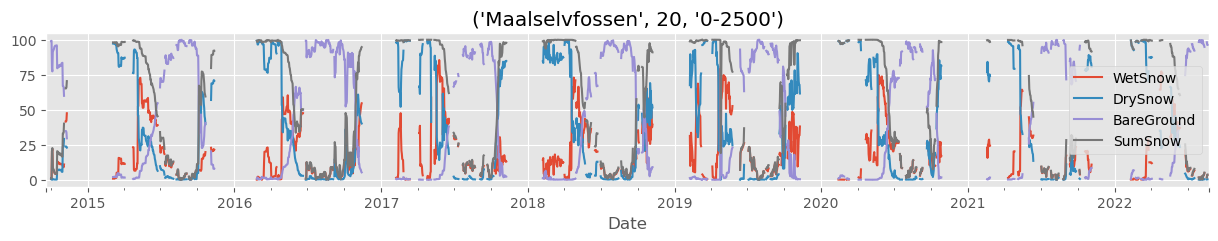

In [3]:
key = ('Maalselvfossen', 20, '0-2500')
df = rs_dict[key]
df.plot(subplots=False, figsize=(15, 2), grid=True, sharex=True, sharey=True);
plt.title(key)
# plt.savefig(r'../figures/snowcover/snowcover_ts.png')

This looks pretty good. The three series sum to 100% (within 0.001 dp), bare ground % increases steadily through spring and then decrease abruptly in winter, in early spring the % wet snow is low and % wet snow is high, then as the spring progresses the % dry snow generally decreases (with peaks), whilst % wet snow increases from low values in early spring to a peak (presumably during peak melt), then decreases to 0.

### Look at threshold vs NaNs

To make sure we're getting a good representation of what's going on in the catchment, Hannah has classed values as NaNs when the % of no data cells was less than a certain % of the whole catchment area. Thresholds included are 5%, 10% and 20%. i.e. under the 20% threshold, if >20% of the catchment cells have no data (e.g. due to cloud cover, shade, etc.) then values for all 3 columns (wet, dry, bare) are replaced with NaNs.

Lets take a quick look at what the choice of threshold means for the number of NaNs.

In [4]:
s_list = []
# Look at number of NaNs
for key in rs_dict.keys():
    nan_count = rs_dict[key].iloc[:,0].isna().sum()
    s = pd.Series(data=list(key) + [nan_count], index=['Catchment', 'Threshold', 'Altitude', 'NaN_count'])
    s_list.append(s)

nan_df = pd.concat(s_list, axis=1).transpose().sort_values(['Catchment', 'Threshold', 'Altitude'])
nan_df.head()

,Catchment,Threshold,Altitude,NaN_count
20,Barduelva,5,0-2500,2005
28,Barduelva,5,0-500,1735
39,Barduelva,5,500-2500,2017
34,Barduelva,10,0-2500,1668
27,Barduelva,10,0-500,1429


/opt/conda/lib/python3.10/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/opt/conda/lib/python3.10/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/opt/conda/lib/python3.10/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/opt/conda/lib/python3.10/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matchin

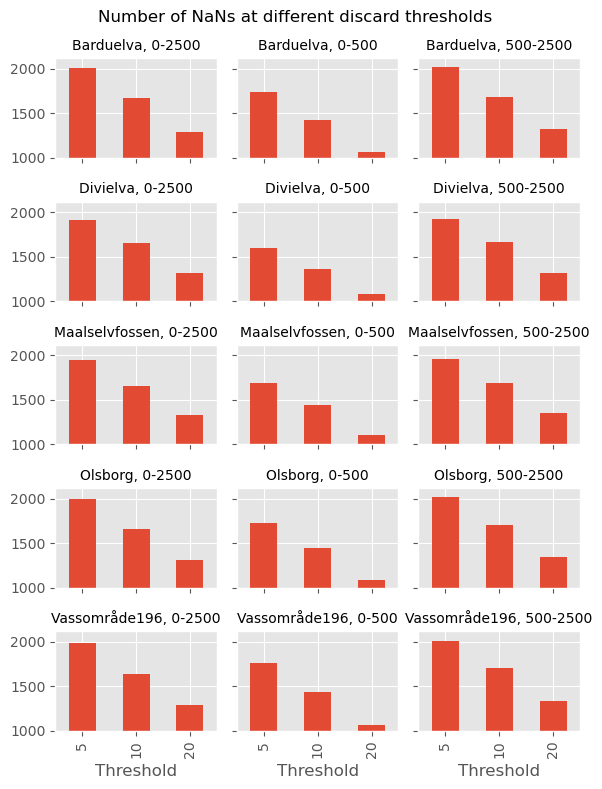

In [5]:
grouped = nan_df.groupby(['Catchment'])

ncols = 3
nrows = 5 #int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 8),
                         sharey=True, sharex=True)
axes = axes.flatten()

# for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
i = 0
for key in grouped.groups.keys():
    catch_grp = grouped.get_group(key)
    alt_grouped = catch_grp.groupby('Altitude')
    for key2 in alt_grouped.groups.keys():
        alt_group = alt_grouped.get_group(key2)
        ax = axes[i]
        alt_group.plot.bar(x='Threshold', y='NaN_count', ax=ax)
        ax.get_legend().remove()
        ax.set_title("%s, %s" % (key, key2), size=10)
        i = i+1
    plt.ylim(ymin=1000)
plt.suptitle('Number of NaNs at different discard thresholds')
plt.tight_layout()
plt.show()

**Generally:**
* The 0-500 altitude band has fewest NaNs and 500-2500 the most
* See a fairly linear relationship between the number of NaNs and the threshold for excluding data
* There's usually about a 40-50% increase in the number of NaNs when the threshold is reduced from 20% to 5% good cells. i.e. a big difference

**Decide to try 10% and see how that goes**

If we're struggling to get good coverage of spring snow melt with that, we can try 20% instead later.

In [6]:
chosen_thresh = 20

### Difference between snow cover/wetness at different altitudes and in different catchments

To do.

## Read in Målselvfossen discharge data and join to snow data

In [8]:
q_fpath = r'../../data/discharge/Q_målselvfossen_alldata_daily-resolution_downloaded-2022-10.csv'
q_df = pd.read_csv(q_fpath, index_col=0, parse_dates=True)
q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,value,unit,correction,quality
datetime,,,,,,,,,,
1965-03-23 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,17.53410,m³/s,1,3
1965-03-24 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,17.09777,m³/s,1,3
1965-03-25 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,16.66732,m³/s,1,3
1965-03-26 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,16.38360,m³/s,2,3
1965-03-27 11:00:00+00:00,196.35.0,Målselvfossen,1001,Vannføring,Discharge,Mean,16.10248,m³/s,2,3


In [9]:
# Tidy
q_df.index = q_df.index.date  # Drop time info (mean applies to day centred on 11:00?)
q_df.rename(columns={'value': 'Q'}, inplace=True)
q_df = q_df['Q']
q_df.head()

1965-03-23    17.53410
1965-03-24    17.09777
1965-03-25    16.66732
1965-03-26    16.38360
1965-03-27    16.10248
Name: Q, dtype: float64

In [10]:
# Join to snow data from Målselvfossen catchment

# Make a dictionary with keys '0-500', '0-2500', '500-2500' (i.e. alt_list)
# joined discharge and snow data for the chosen threshold
join_dict = {}
for alt in alt_list:
    rs_df = rs_dict['Maalselvfossen', chosen_thresh, alt]
    joined_df = rs_df.merge(q_df, left_index=True, right_index=True)
    join_dict[alt] = joined_df

## Compare snow and Q at Målselvfossen

To do:

* Time series of wet snow and Q, maybe grouped by year
* Regression (with lag?) between the two?
* Does it make a difference when we split by altitude?

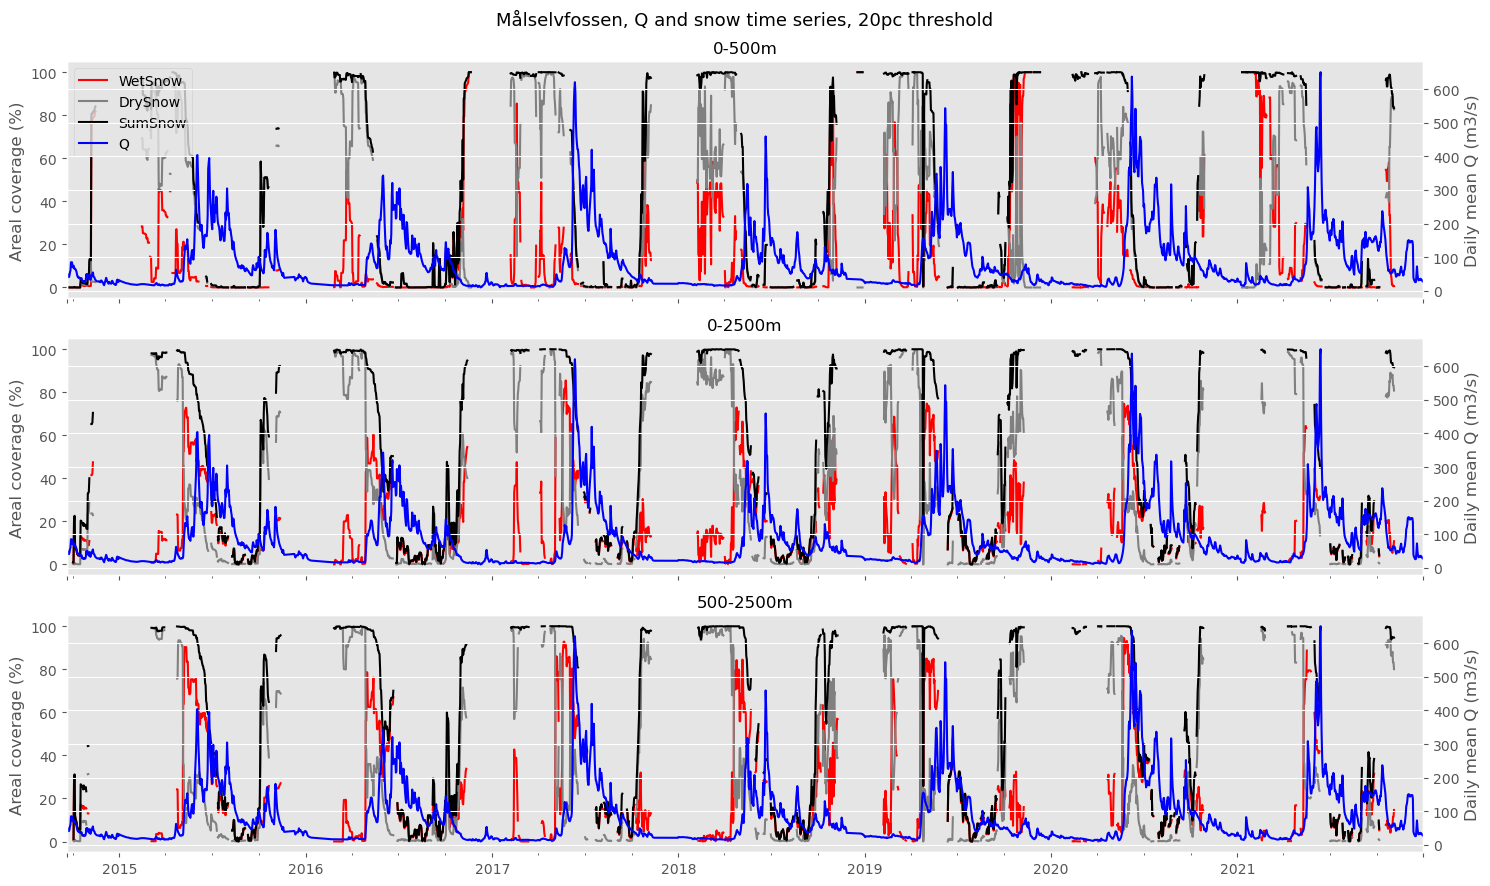

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)

for i, band in enumerate(alt_list):

    df = join_dict[band]

    # Plot all years on one plot
    df[['WetSnow', 'DrySnow', 'SumSnow']].plot(figsize=(15, 9), color=['red', 'gray', 'black'],
                                               legend=False, ax=axs[i])
    ax2 = df['Q'].plot(secondary_y=True, color='b', ax=axs[i], mark_right=False)

    # Label axes
    axs[i].set_ylabel('Areal coverage (%)')
    ax2.set_ylabel('Daily mean Q (m3/s)')

    # Sort out the legend (complicated a bit by having the second axis)
    l1 = axs[i].get_lines()
    l2 = ax2.get_lines()
    lns = l1+l2
    labs = [l.get_label() for l in lns]

    if i==0:
        axs[i].legend(lns, labs, loc='upper left')

    axs[i].set_title(f'{band}m', size=12)

plt.suptitle(r"Målselvfossen, Q and snow time series, %spc threshold" % chosen_thresh, size=13)
plt.tight_layout()

plt.savefig(r'../figures/Målselvfossen_Q_%spercent_allyears.png' % chosen_thresh)

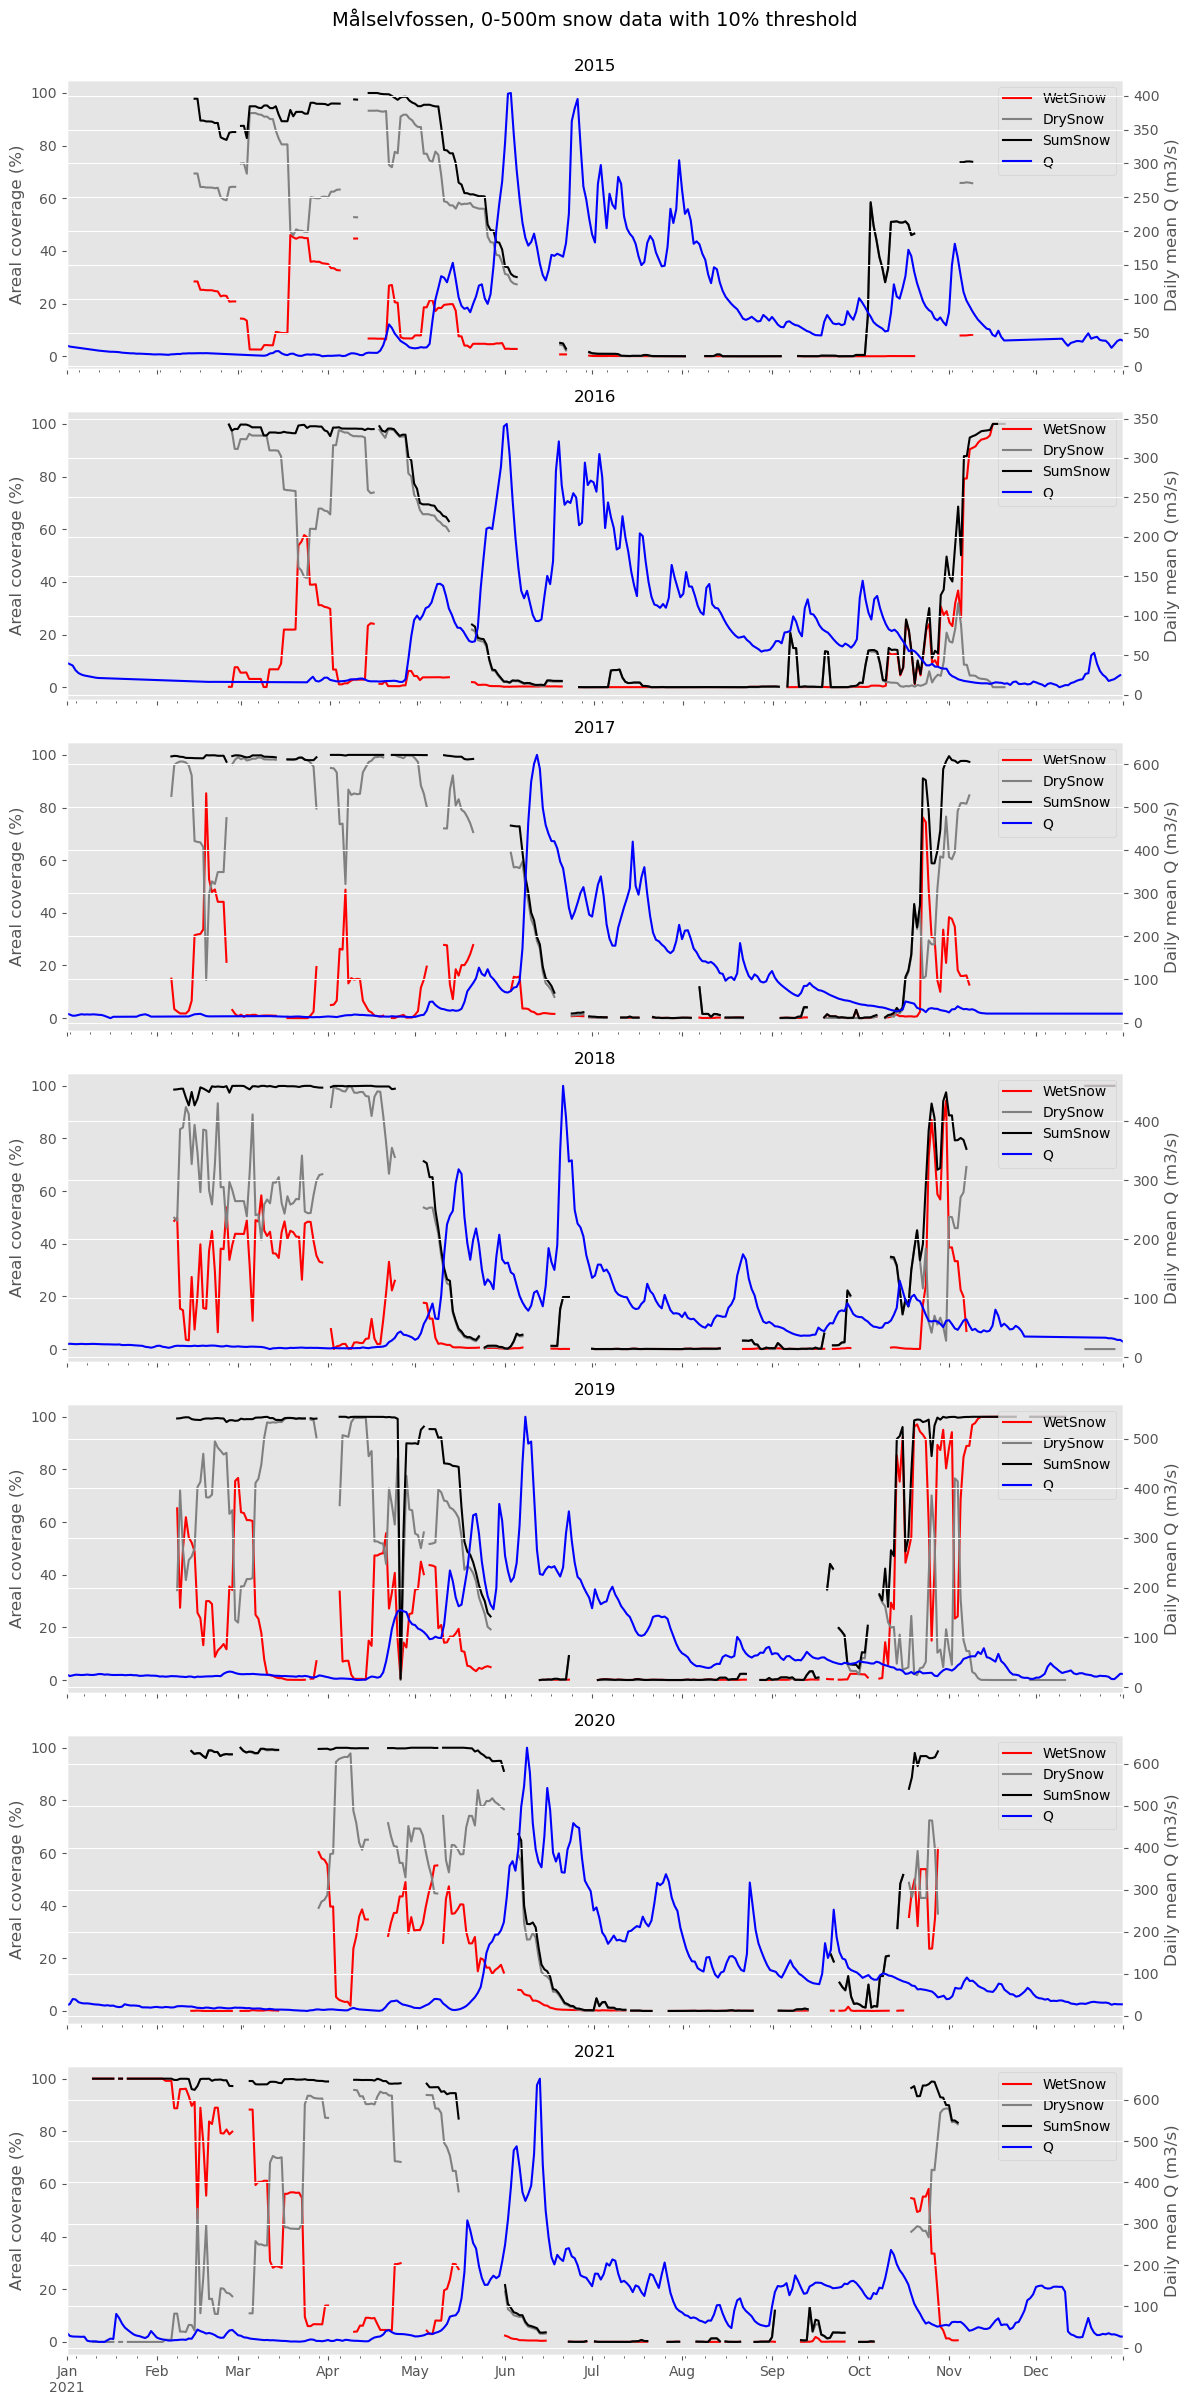

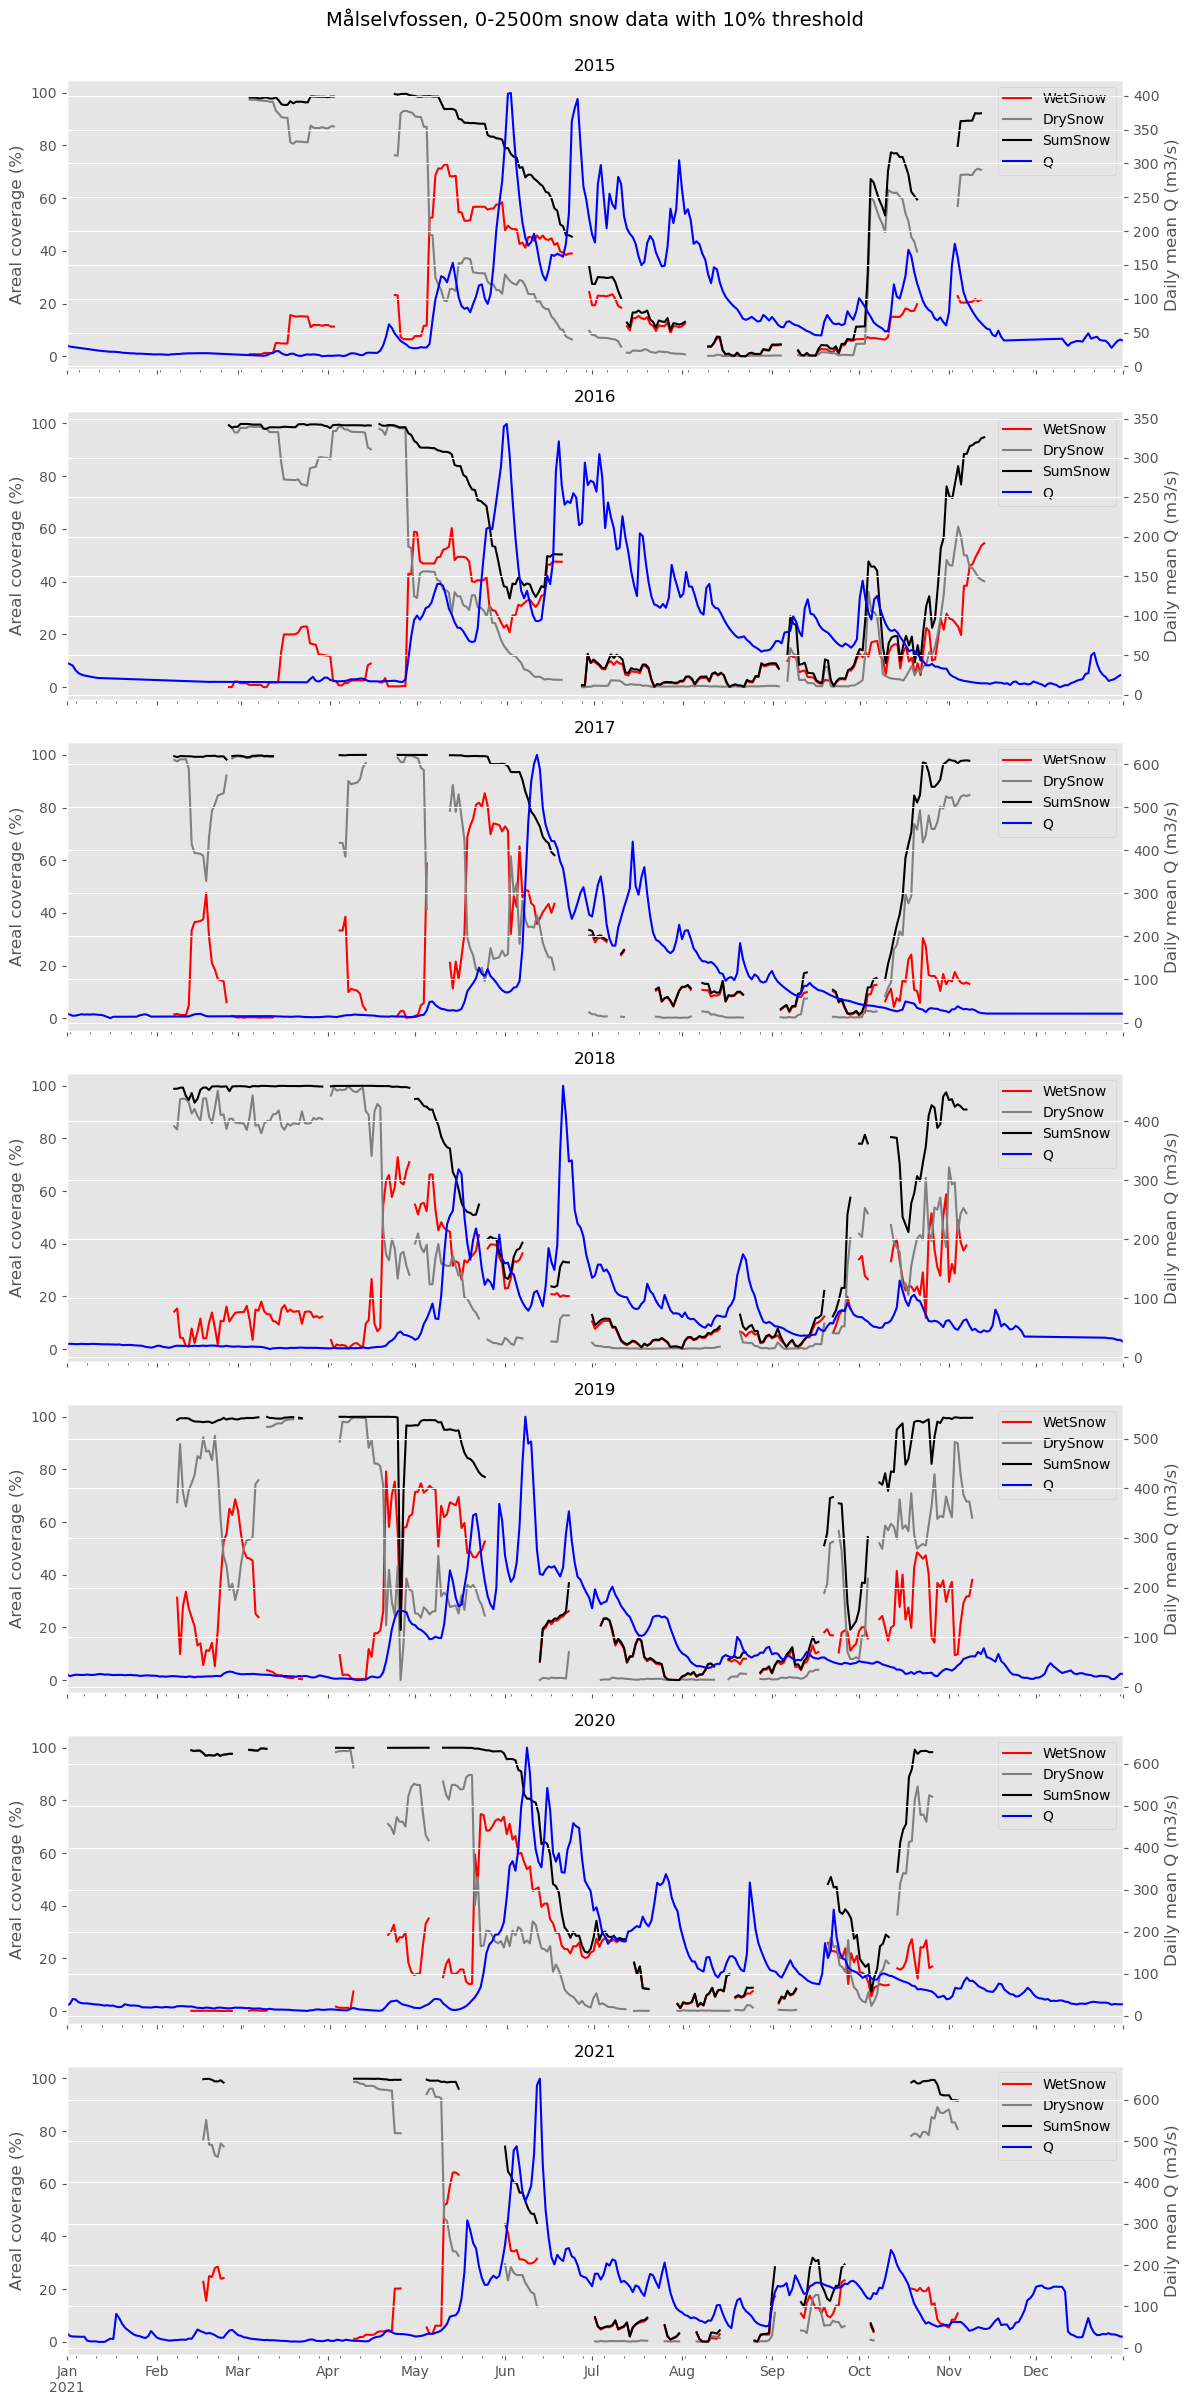

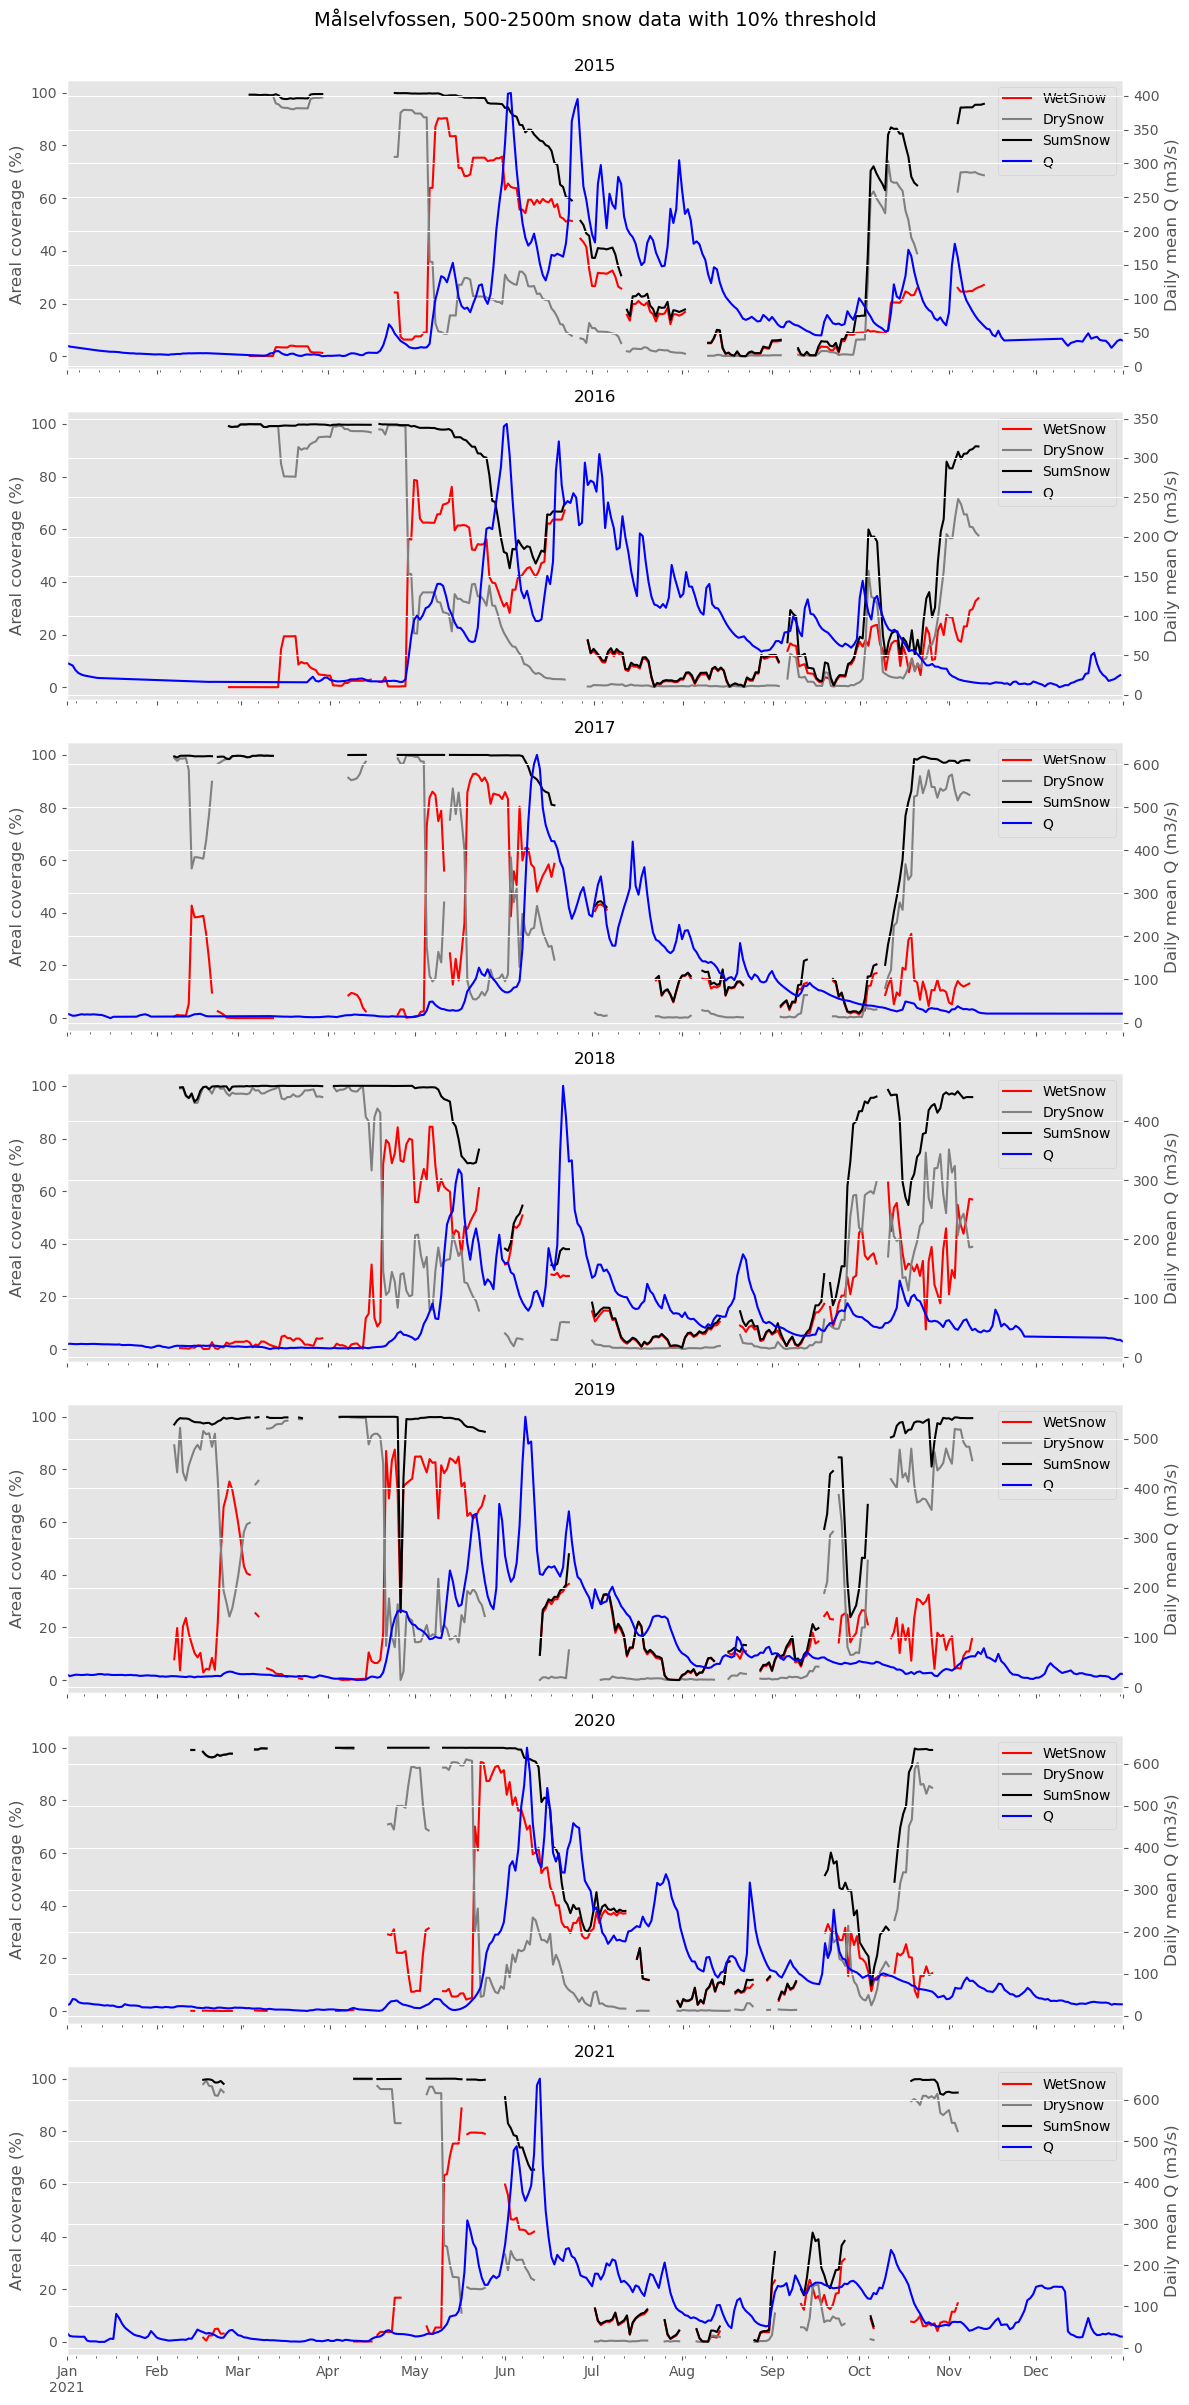

In [13]:
# Plot year by year

# Years to plot for
yr_list = list(range(2015, 2022))

# Snow variables you want to plot
snow_vars = ['WetSnow', 'DrySnow', 'SumSnow']
# snow_vars = ['WetSnow', 'DrySnow']
# snow_vars = ['SumSnow']

# Sort title to use in file name
if len(snow_vars) == 1:
    snow_title = "SumSnow"
elif len(snow_vars) < 3:
    snow_title = "WetDrySnow"
else:
    snow_title = "AllSnowVars"

# Loop through altitude bands and plot
for band in alt_list:

    df = join_dict[band]

    fig = plt.figure(figsize=(12, 25))

    for i, year in enumerate(yr_list):

        # Select data for current year
        df_yr = df.loc['%s-01-01' % year: '%s-12-31' % year]

        # Plot
        ax1 = fig.add_subplot(len(yr_list), 1, i+1)

        df_yr[snow_vars].plot(color=['red', 'gray', 'black'], legend=False, ax=ax1)
        ax2 = df_yr['Q'].plot(secondary_y=True, color='b', ax=ax1, mark_right=False)

        # Label axes
        ax1.set_ylabel('Areal coverage (%)')
        ax2.set_ylabel('Daily mean Q (m3/s)')
        plt.xlabel('')

        # Turn off x tick labels for all but the last plot
        if year != 2021:
            frame1 = plt.gca()
            frame1.axes.xaxis.set_ticklabels([])

        ax1.set_title(year, size=12)

        # Sort out the legend (complicated a bit by having the second axis)
        l1 = ax1.get_lines()
        l2 = ax2.get_lines()
        lns = l1+l2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc='upper right')

    fig.suptitle(f"Målselvfossen, {band}m snow data with 10% threshold", size=14)
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.savefig(f'../figures/Målselvfossen_Q_{snow_title}_{band}_{chosen_thresh}%_yrbyyr.png')

**Some observations from the plots**
* 0-500m:
    * The wet snow peak in the 0-500m range happens early, and you only tend to get the discharge peak when the wet snow peak has almost passed (or down to around <~20%)
    * Dry snow hangs around longer than wet snow at this altitude (icey)
    * i.e. the start of the big river flow peak tends to coincide with the end of the wet snow peak, and the time when % snow cover starts to drop below 95%'ish.
* 500-2500m:
   * Get a sudden drop in dry snow coverage and a sudden increase in wet snow coverage about the time when the river discharge starts to increase due to snowmelt
   * % total snow cover starts to drop down from 100% at or just before the time of the first big river flow peak.

**Next steps:**
To discuss, but ideas would be:
* Spend a little bit of time cleaning the remote sensing data. e.g. Interpolate some of the shorter gaps, and remove the odd artefact (e.g. 2019, see dodgy drop in spring snow cover that's clearly an artefact)
* Only focus on timing of snow melt and corresponding discharge, as autumn snow cover can be 100% and yet when it melts causes only a very small flow peak
* Think about how to come up with a statistical relationship between snow cover and flow.

## Compare in-stream water quality sensor data and remote sensing snow data

To do.